In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import sem
import matplotlib.cm as cm
import pickle
import pandas as pd
import h5py
import torch

# Global variables

In [66]:
models = [
    'pnet', 'pnet_phaseshuffle', 'pnet_magshuffle', 'random', 'pnet_allshuffle'
    ]

In [4]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn_vision/'
dataset_root = f'{engram_dir}imagenet/'
ckpt_root = f'{engram_dir}checkpoints/'
hps_root = f'{engram_dir}hyperparams/'
activations_root = f'{engram_dir}activations/'

# Helper functions

In [5]:
def get_accuracy(results):
    labels = np.array(results['labels'])
    timesteps = []
    accuracies = [] # p
    delta_accuracies = [] # p - p_ff
    
    n_timesteps = 5
    for i in range(labels.size):
        label = labels[i]
        ff_acc = None
        for t in range(n_timesteps):
            output = results[f'label_{t}'][i]
            acc_t = (output == label).astype(float)
            if t == 0:
                ff_acc = acc_t
            timesteps.append(t)
            accuracies.append(acc_t)
            delta_accuracies.append(acc_t - ff_acc)

    timesteps = np.array(timesteps)
    accuracies = np.array(accuracies)
    delta_accuracies = np.array(delta_accuracies)
            
    return timesteps, accuracies, delta_accuracies

In [59]:
def get_data(model):
    data = {}
    data['Accuracy'] = [] # p
    data['$\Delta$ Accuracy'] = [] # p - p_ff for each bg, snr
    data['Timesteps'] = []
    data['Noise Level'] = []
    data['BG'] = []
    data['ID'] = []

    for noise_dir in os.listdir(f'{activations_root}{model}'):
        if '_lvl_' not in noise_dir: continue
        bg, noise_level = noise_dir.split('_lvl_')
        activ_dir = f'{activations_root}{model}/{noise_dir}/'
        for results_file in os.listdir(activ_dir):
            results_filepath = f'{activ_dir}{results_file}'
            try:
                results = h5py.File(results_filepath, 'r')
            except:
                print(results_filepath)
                traceback.print_exc()
                continue
            timesteps, accs, delta_accs = get_accuracy(results)

            # Collect accuracy results by labels
            for t in [0, 1, 2, 3, 4]:
                idxs = timesteps==t
                data['Accuracy'].append(np.mean(accs[idxs]))
                data['$\Delta$ Accuracy'].append(np.mean(delta_accs[idxs]))
                data['Timesteps'].append(t)
                data['Noise Level'].append(int(noise_level))
                data['BG'].append(bg)
                data['ID'].append(results_file)
    df = pd.DataFrame(data)

    bg_avgs = {}
    for bg in np.unique(df['BG']):
        bg_avgs[bg] = {}
        for noise_level in np.unique(df['Noise Level']):
            ff_df = df[df['Timesteps']==0]
            bg_avgs[bg][noise_level] = np.mean(
                ff_df[(ff_df['BG'] == bg) & (ff_df['Noise Level'] ==noise_level)]['Accuracy']
                )
    data['Relative Accuracy'] = [] # (p - p_ff)/p_ff
    for idx in range(len(data['Accuracy'])):
        bg = data['BG'][idx]
        noise_level = data['Noise Level'][idx]
        delta_acc = data['$\Delta$ Accuracy'][idx]
        data['Relative Accuracy'].append(delta_acc/bg_avgs[bg][noise_level])
    df = pd.DataFrame(data)
    return df

# Collect Data

In [67]:
dfs = []
for model in models:
    dfs.append(get_data(model))

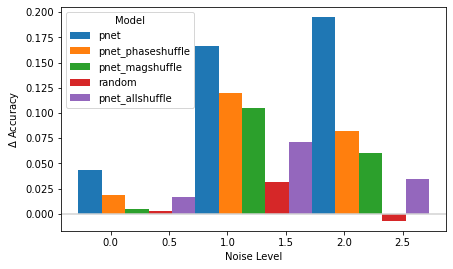

In [68]:
barWidth = 0.2
x1 = np.arange(5) - barWidth*1.75/2
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
bg = 'gaussian_noise'

for noise_level in [1, 2, 3]:
    t = 4
    for model_idx, model in enumerate(models):
        df = dfs[model_idx]
        df = df[(df['Noise Level']==noise_level) & (df['BG']==bg)]
        df = df[df['Timesteps']==t]
        vals = df['$\Delta$ Accuracy']
        vals = np.array(vals)
        avg = np.mean(vals)
        err = sem(vals)
        label = model if noise_level==1 else None
        plt.bar(
            x1[noise_level-1] + barWidth*model_idx, avg,
            width=barWidth, color=colors[model_idx],
            yerr=err, capsize=0, label=label)
plt.ylabel('$\Delta$ Accuracy')
plt.xlabel('Noise Level')
plt.axhline(0, color='lightgray')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('gaussian_noise_acc.png', dpi=300)
plt.show()

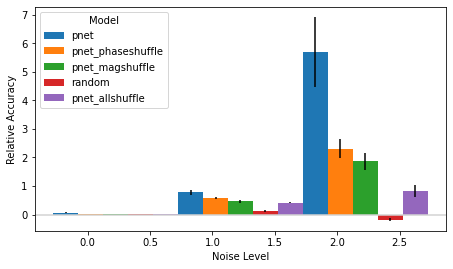

In [69]:
barWidth = 0.2
x1 = np.arange(5) - barWidth*1.75/2
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
bg = 'gaussian_noise'

for noise_level in [1, 2, 3]:
    t = 4
    for model_idx, model in enumerate(models):
        df = dfs[model_idx]
        df = df[(df['Noise Level']==noise_level) & (df['BG']==bg)]
        df = df[df['Timesteps']>0]
        vals = df['Relative Accuracy']
        vals = np.array(vals)
        avg = np.mean(vals)
        err = sem(vals)
        label = model if noise_level==1 else None
        plt.bar(
            x1[noise_level-1] + barWidth*model_idx, avg,
            width=barWidth, color=colors[model_idx],
            yerr=err, capsize=0, label=label)
plt.ylabel('Relative Accuracy')
plt.xlabel('Noise Level')
plt.axhline(0, color='lightgray')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('gaussian_noise_acc.png', dpi=300)
plt.show()

/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)


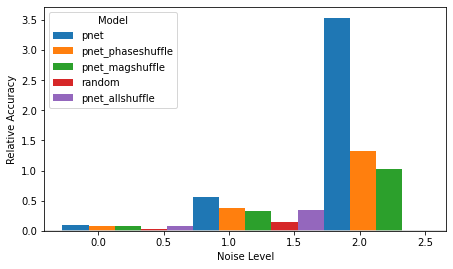

In [70]:
barWidth = 0.2
x1 = np.arange(5) - barWidth*1.75/2
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
bg = 'impulse_noise'

for noise_level in [1, 2, 3]:
    t = 4
    for model_idx, model in enumerate(models):
        df = dfs[model_idx]
        df = df[(df['Noise Level']==noise_level) & (df['BG']==bg)]
        df = df[df['Timesteps']==t]
        vals = df['Relative Accuracy']
        vals = np.array(vals)
        avg = np.mean(vals)
        err = sem(vals)
        label = model if noise_level==1 else None
        plt.bar(
            x1[noise_level-1] + barWidth*model_idx, avg,
            width=barWidth, color=colors[model_idx],
            yerr=err, capsize=0, label=label)
plt.ylabel('Relative Accuracy')
plt.xlabel('Noise Level')
plt.axhline(0, color='lightgray')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('gaussian_noise_acc.png', dpi=300)
plt.show()